Tic Tac Toe Spielstanderkenner

Ziel dieser Arbeit ist es, dass Bilder eines Tic Tac Toe Spiels eingegeben werden und der Spielstand automatisch erkannt wird. Wenn es einen Gewinner gibt, soll dieser Markiert und ausgegeben werden

Schritt 1 Bilder einlesen

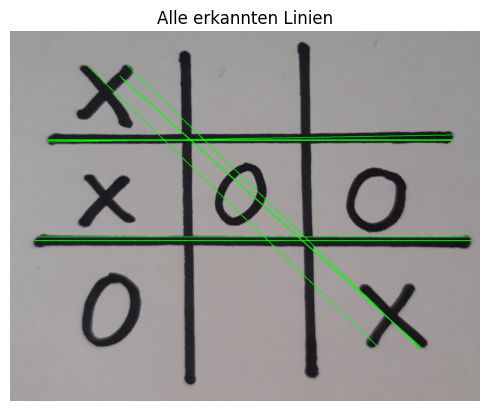

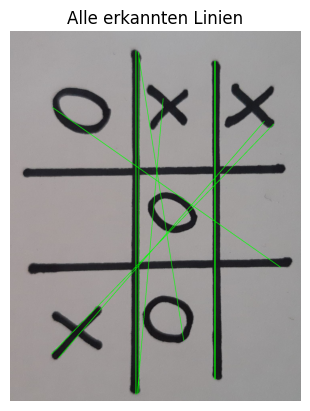

(1854, 1458)
(1458, 1854)


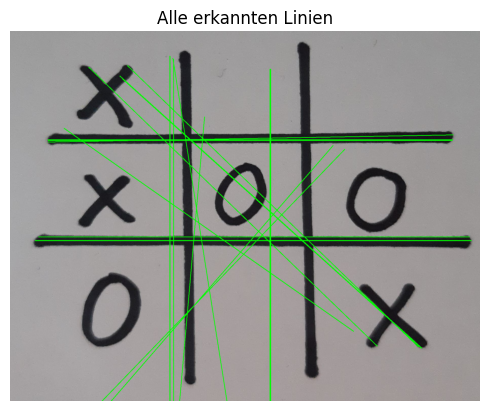

x-ungeclustert: [np.int32(630), np.int32(631), np.int32(645), np.int32(1028), np.int32(1027), np.int32(1026), np.int32(1025), np.int32(702), np.int32(756)]
x-geclustert: [672, 1026]
y-ungeclustert: [np.int32(826), np.int32(825), np.int32(811), np.int32(423), np.int32(428), np.int32(429), np.int32(430), np.int32(431)]
y-geclustert: [428, 820]


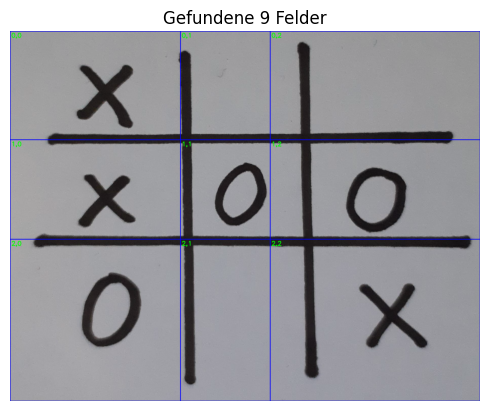

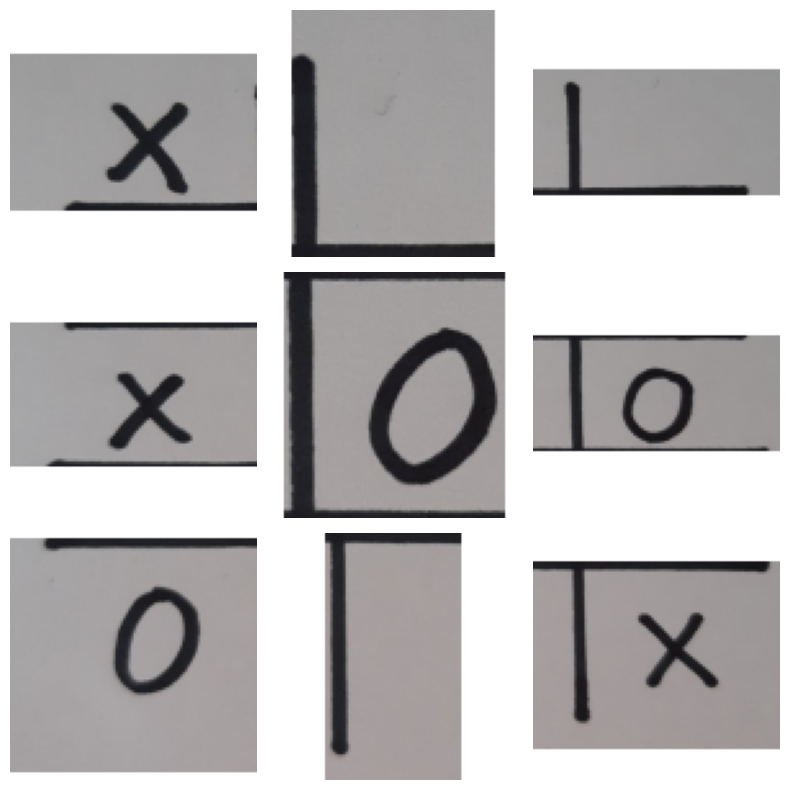

In [182]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import color

def show_image(image, title=None):
    plt.imshow(image, cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def cluster_coords(coords, mindist=20):
    if not coords:
        return []
    coords = sorted(coords)
    clustered = []
    current = [coords[0]]
    for c in coords[1:]:
        if abs(c - current[-1]) < mindist:
            current.append(c)
        else:
            clustered.append(int(np.mean(current)))
            current = [c]
    clustered.append(int(np.mean(current)))
    return clustered

def get_two_most_centered(coords, img_size):
    if len(coords) < 2:
        return [img_size//3, 2*img_size//3]  # Fallback: mittig geschätzt
    targets = [img_size//3, 2*img_size//3]
    selected = []
    coords = sorted(coords)
    for t in targets:
        best = min(coords, key=lambda c: abs(c - t))
        selected.append(best)
        coords.remove(best)
    return sorted(selected)

def get_line_centers(lines, img_size, axis='x'):
    coords = []
    if lines is not None:
        for l in lines:
            x1,y1,x2,y2 = l[0]
            if axis=='x' and abs(x1-x2) < img_size*0.15:
                coords.append((x1+x2)//2)
            if axis=='y' and abs(y1-y2) < img_size*0.15:
                coords.append((y1+y2)//2)
    mind = 15 if axis=='y' else int(img_size*0.04)
    clustered = cluster_coords(coords, mindist=mind)
    print(f"{axis}-ungeclustert:", coords)
    print(f"{axis}-geclustert:", clustered)
    return clustered

def filter_longest_lines(lines, num=12):
    if lines is None or len(lines)==0:
        return []
    segs = [l[0] for l in lines]
    segs.sort(key=lambda l:(l[2]-l[0])**2+(l[3]-l[1])**2, reverse=True)
    return np.array([[s] for s in segs[:num]])

def crop_to_largest_contour(binary, img):
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return binary, img
    x,y,w,h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    pad = int(0.04 * max(w,h))
    x,y = max(0,x-pad), max(0,y-pad)
    w,h = min(binary.shape[1]-x, w+2*pad), min(binary.shape[0]-y, h+2*pad)
    return binary[y:y+h, x:x+w], img[y:y+h, x:x+w]

def get_lines(grid_only, img_orig, kernel, binary):
    edges = cv2.Canny(grid_only, 20, 70, apertureSize=3)
    #show_image(edges, "Edges nach Grid Crop")
    #show_image(edges_rotatetd, "Edges_rotated nach Grid Crop")

    h, w = grid_only.shape
    min_dim = min(h,w)
    minL = int(min_dim*0.1)
    maxG= int(min_dim*0.25)

    lines = cv2.HoughLinesP(
        edges, 1, np.pi/180,
        threshold=15, 
        minLineLength=minL, 
        maxLineGap=maxG
    )

    # if no lines found, fallback to contour-crop
    if lines is None or len(lines) == 0:
        print("Warnung: Keine Linien gefunden, kontur-basiertes Zuschneiden")
        binary, img_cropped = crop_to_largest_contour(binary, img_orig)
        grid_only = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        grid_only = cv2.morphologyEx(grid_only, cv2.MORPH_OPEN, kernel)
        img = img_cropped
    else:
        # split vertical/horizontal segments
        verts = [l[0] for l in lines if abs(l[0][0] - l[0][2]) < 5]
        hors  = [l[0] for l in lines if abs(l[0][1] - l[0][3]) < 5]

        # get two inner grid coords
        xs = sorted((x1+x2)//2 for x1,y1,x2,y2 in verts)
        ys = sorted((y1+y2)//2 for x1,y1,x2,y2 in hors)
        xs = get_two_most_centered(xs, w)
        ys = get_two_most_centered(ys, h)

        # build boundaries
        x_coords = [0] + xs + [w]
        y_coords = [0] + ys + [h]

        # perform cropping
        x1, x2 = x_coords[0], x_coords[-1]
        y1, y2 = y_coords[0], y_coords[-1]
        img = img_orig[y1:y2, x1:x2]
        binary = binary[y1:y2, x1:x2]
        grid_only = grid_only[y1:y2, x1:x2]

    #show_image(grid_only, "Grid only nach Crop")

    # now standard field extraction
    edges = cv2.Canny(grid_only, 20, 70, apertureSize=3)
    #show_image(edges, "Edges nach Grid Crop")

    h, w = grid_only.shape
    min_dim = min(h,w)
    minL = int(min_dim*0.1)
    maxG= int(min_dim*0.25)

    lines = cv2.HoughLinesP(
        edges, 1, np.pi/180,
        threshold=10, minLineLength=minL, maxLineGap=maxG
    )
    lines = filter_longest_lines(lines, num=12)
    
    if lines is not None and len(lines):
        dbg = img.copy()
        for l in lines:
            x1,y1,x2,y2 = l[0]
            cv2.line(dbg, (x1,y1), (x2,y2), (0,255,0), 2)
        show_image(cv2.cvtColor(dbg, cv2.COLOR_BGR2RGB), "Alle erkannten Linien")
    return lines, img

def detect_tic_tac_toe_grid(img_path):
    img_orig = cv2.imread(img_path)
    gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 7)

    # adaptive threshold
    binary = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=51, C=7
    )
    #show_image(binary, "Binary Threshold")

    # extract grid mask
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
    grid_only = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    grid_only = cv2.morphologyEx(grid_only, cv2.MORPH_OPEN, kernel)
    h, w = grid_only.shape
    #show_image(grid_only, "Grid only")
    lines_h, img = get_lines(grid_only, img_orig, kernel, binary)
    lines_v, img_v = get_lines(cv2.rotate(grid_only, cv2.ROTATE_90_CLOCKWISE), cv2.rotate(img_orig, cv2.ROTATE_90_CLOCKWISE), kernel, cv2.rotate(binary, cv2.ROTATE_90_CLOCKWISE))
    #Rotiertes Bild für bessere Vertikale erkennung
    # Linien im rotierten Bild (sind horizontale dort -> vertikale im Original)
    print(cv2.rotate(grid_only, cv2.ROTATE_90_CLOCKWISE).shape)
    print(grid_only.shape)
    
    def rotate(line):
        v1 = np.array(line[0][:2])
        v2 = np.array(line[0][2:])
        r = np.matrix([[math.cos(np.pi/2), -math.sin(np.pi/2)],
                       [math.sin(np.pi/2), math.cos(np.pi/2)]])
        
        v1_rotated = r @ v1.T
        v2_rotated = r @ v2.T
        return np.concatenate((v1_rotated, v2_rotated)).astype(int).reshape(1, 4)
    
    
    for line in lines_v:
        line = cv2.rotate(line, cv2.ROTATE_90_COUNTERCLOCKWISE)
    lines = np.concatenate((lines_h, lines_v), axis=0)  

    if lines is not None and len(lines):
        dbg = img.copy()
        for l in lines:
            x1,y1,x2,y2 = l[0]
            cv2.line(dbg, (x1,y1), (x2,y2), (0,255,0), 2)
        show_image(cv2.cvtColor(dbg, cv2.COLOR_BGR2RGB), "Alle erkannten Linien")

    x_centers = get_line_centers(lines, w, axis='x')
    y_centers = get_line_centers(lines, h, axis='y')
    vx = get_two_most_centered(x_centers, w)
    hy = get_two_most_centered(y_centers, h)

    x_coords = [0] + vx + [w]
    y_coords = [0] + hy + [h]

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_grid = img_rgb.copy()
    field_bilder, positionen = [], []

    for row in range(3):
        for col in range(3):
            xa, xb = x_coords[col], x_coords[col+1]
            ya, yb = y_coords[row], y_coords[row+1]
            feld = img[ya:yb, xa:xb]
            field_bilder.append(feld)
            positionen.append((row, col))
            cv2.rectangle(img_grid, (xa,ya), (xb,yb), (255,0,0), 2)
            cv2.putText(img_grid, f"{row},{col}", (xa+5, ya+25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

    show_image(cv2.cvtColor(img_grid, cv2.COLOR_BGR2RGB), "Gefundene 9 Felder")
    return field_bilder, positionen

def crop_and_resize_field(field_img, size=96, pad_color=(255,255,255)):
    h,w = field_img.shape[:2]
    scale = size / max(h,w)
    nh,nw = int(h*scale), int(w*scale)
    resized = cv2.resize(field_img, (nw,nh), interpolation=cv2.INTER_AREA)
    canvas = np.full((size,size,3), pad_color, dtype=np.uint8)
    ys, xs = (size-nh)//2, (size-nw)//2
    canvas[ys:ys+nh, xs:xs+nw] = resized
    return canvas

def show_9_fields(field_bilder, positionen, size=96):
    fig, axs = plt.subplots(3,3, figsize=(8,8))
    for img_cell,(r,c) in zip(field_bilder, positionen):
        norm = crop_and_resize_field(img_cell, size)
        axs[r,c].imshow(cv2.cvtColor(norm, cv2.COLOR_BGR2RGB))
        axs[r,c].axis('off')
    plt.tight_layout()
    plt.show()

# Beispiel-Aufruf
#field_bilder, positionen = detect_tic_tac_toe_grid('Test_Fabi/noisy_2.png') 
field_bilder, positionen = detect_tic_tac_toe_grid('Test_Wiebke/feld_3.jpg')
show_9_fields(field_bilder, positionen)


In [183]:
import cv2
import numpy as np

def preprocess_field(img_field):
    gray = cv2.cvtColor(img_field, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    thresh = cv2.adaptiveThreshold(
        blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 3
    )
    return thresh

def is_mostly_empty(thresh_img, area_thresh=0.01):
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    total_area = thresh_img.shape[0] * thresh_img.shape[1]
    filled_area = sum(cv2.contourArea(cnt) for cnt in contours)
    return (filled_area / total_area) < area_thresh

def detect_O(thresh_img):
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv2.contourArea(cnt) #berechnet fläche von contur
        if area < 90: continue  # raus mit kleinen Resten
        perimeter = cv2.arcLength(cnt, True)    #berechnet umfang von contur
        if perimeter == 0: continue
        circularity = 4 * np.pi * (area / (perimeter ** 2))
        if 0.2 < circularity <= 1.6:  # Kreisförmig
            return True
    return False


def lines_intersect(line1, line2):
    def ccw(A, B, C):
        return (C[1]-A[1])*(B[0]-A[0]) > (B[1]-A[1])*(C[0]-A[0])

    A = (line1[0], line1[1])
    B = (line1[2], line1[3])
    C = (line2[0], line2[1])
    D = (line2[2], line2[3])

    return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)


def detect_X(thresh_img):
    lines = cv2.HoughLines(thresh_img, 1, np.pi / 180, threshold=100)
    if lines is None or len(lines) < 2:
        return False

    angles = []

    for line in lines:
        rho, theta = line[0]
        angle_deg = theta * 180 / np.pi
        angles.append(angle_deg)

    # Suche typische X-Winkel: ungefähr 45° und 135°
    found_45 = any(30 <= a <= 60 for a in angles)
    found_135 = any(120 <= a <= 150 for a in angles)

    return found_45 and found_135




def classify_tic_tac_toe_field(img_field):
    thresh = preprocess_field(img_field)

    if is_mostly_empty(thresh):
        return "empty"
    elif detect_O(thresh):
        return "O"
    elif detect_X(thresh):
        return "X"
    else:
        return "empty"


In [172]:
 
def show_contours_with_info(img_field, thresh_img):
    # Konturen finden
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Kopie zum Zeichnen
    img_draw = img_field.copy()
    print(f"Gefundene Konturen: {len(contours)}")
    for i, cnt in enumerate(contours):

        area = cv2.contourArea(cnt)
        if area < 50: continue  # Filter wie in detect_O
        
        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0: continue
        circularity = 4 * np.pi * (area / (perimeter ** 2))

        # Kontur zeichnen
        cv2.drawContours(img_draw, [cnt], -1, (0, 255, 0), 2)

        # Bounding box & Textposition
        x, y, w, h = cv2.boundingRect(cnt)
        label = f"#{i} A:{int(area)} C:{circularity:.2f}"
        cv2.putText(img_draw, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)

    # Anzeige mit matplotlib
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
    plt.title("Konturen mit Fläche & Zirkularität")
    plt.axis("off")
    plt.show()

def debug_draw_lines(thresh_img, original_img):
    lines = cv2.HoughLines(thresh_img, 1, np.pi / 180, threshold=100)
    if lines is None:
        return
    img_copy = original_img.copy()
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv2.line(img_copy, (x1,y1), (x2,y2), (0,0,255), 2)

    cv2.imshow("X-Lines Debug", img_copy)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [184]:
results = []
for img in field_bilder:
    #show_contours_with_info(img, preprocess_field(img))
    #debug_draw_lines(preprocess_field(img), img)
    symbol = classify_tic_tac_toe_field(img)
    results.append(symbol)
    print(symbol)

X
empty
empty
X
O
O
O
empty
X


In [185]:
def check_winner(results):
    winning_combinations = [
        (0, 1, 2),  # erste Reihe
        (3, 4, 5),  # zweite Reihe
        (6, 7, 8),  # dritte Reihe
        (0, 3, 6),  # erste Spalte
        (1, 4, 7),  # zweite Spalte
        (2, 5, 8),  # dritte Spalte
        (0, 4, 8),  # Diagonale von links oben nach rechts unten
        (2, 4, 6),  # Diagonale von rechts oben nach links unten
    ]
    winner = []
    for a, b, c in winning_combinations:
        if results[a] != 'empty' and results[a] == results[b] == results[c]:
            winner.append(results[a]) 
            
    match len(winner):
        case 0:
            return 'Keiner'    
        case 1:
            return winner[0]  # 'X' oder 'O'    
        case 2:
            return 'x & o'    


#results = ['x', 'x', 'x', 'o', 'o', 'o', 'o', 'empty', 'o']
print(f"{check_winner(results)} hat gewonnen")  # Ausgabe: 'x'

Keiner hat gewonnen
